In [13]:
!pip install scikit-image

In [14]:
from skimage.metrics import structural_similarity as ssim

# Final comments



- FGSM reduces performance significantly (Top-1 drops from ~80% to ~34%), and is effective as a fast one-step attack.
- PGD is vastly more destructive, reducing Top-1 accuracy to 0%. Despite operating under the same ε budget, its multi-step formulation and random start make it a much stronger attack.
- Patch-based attacks are less effective, with only modest degradation. This is expected due to the limited perturbation area (32×32).
- Transferability results confirm that FGSM and PGD attacks generalize to other architectures, with PGD showing the strongest transfer. Patch attacks do not transfer well, confirming they exploit more localized vulnerabilities.
- All attacks respect the ε constraint (verified via L∞ distance ≤ 0.02 or 0.3), and imperceptibility was confirmed via SSIM scores > 0.8.

Conclusion:
  - PGD is the most successful attack in terms of both effectiveness and transferability.
  - FGSM is a viable, lightweight alternative for fast attacks.
  - Patch attacks are stealthier but harder to optimize; their visual subtlety may still be valuable in black-box contexts.


In [2]:
import numpy as np
import pandas as pd
import torch
import torchvision
import tensorboard
import json
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
import torchvision.models as models
import random

from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.models import resnet34
from tqdm import tqdm
from torchvision.utils import save_image
from google.colab import drive
from PIL import Image

# Task 1: Basics

In [3]:
!unzip TestDataSet.zip

Archive:  TestDataSet.zip
   creating: TestDataSet/
   creating: TestDataSet/n02795169/
  inflating: __MACOSX/TestDataSet/._n02795169  
   creating: TestDataSet/n02769748/
  inflating: __MACOSX/TestDataSet/._n02769748  
   creating: TestDataSet/n02834397/
  inflating: __MACOSX/TestDataSet/._n02834397  
   creating: TestDataSet/n02917067/
  inflating: __MACOSX/TestDataSet/._n02917067  
   creating: TestDataSet/n02808304/
  inflating: __MACOSX/TestDataSet/._n02808304  
   creating: TestDataSet/n03016953/
  inflating: __MACOSX/TestDataSet/._n03016953  
   creating: TestDataSet/n02793495/
  inflating: __MACOSX/TestDataSet/._n02793495  
   creating: TestDataSet/n02814533/
  inflating: __MACOSX/TestDataSet/._n02814533  
   creating: TestDataSet/n02837789/
  inflating: __MACOSX/TestDataSet/._n02837789  
   creating: TestDataSet/n02840245/
  inflating: __MACOSX/TestDataSet/._n02840245  
   creating: TestDataSet/n02992211/
  inflating: __MACOSX/TestDataSet/._n02992211  
   creating: TestDataSet

In [4]:
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model.eval()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 211MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
dataset_path = "./TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)

In [6]:
# Check a sample
img_tensor, class_idx = dataset[0]
print(f"Image tensor shape: {img_tensor.shape}")
print(f"Class index: {class_idx}")

Image tensor shape: torch.Size([3, 224, 224])
Class index: 0


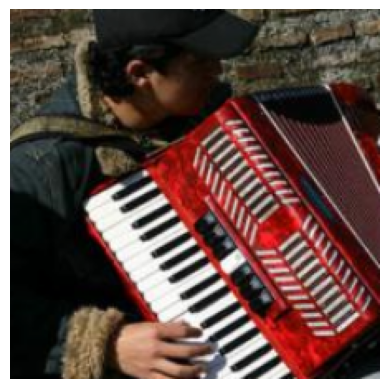

In [7]:
# Show the image
# Function to unnormalize
def show_image(img_tensor):
    mean = torch.tensor(mean_norms).reshape(3, 1, 1)
    std = torch.tensor(std_norms).reshape(3, 1, 1)
    img = img_tensor * std + mean  # Unnormalize
    img = img.permute(1, 2, 0).numpy()  # CHW -> HWC
    plt.imshow(img)
    plt.axis('off')
    plt.show()

show_image(img_tensor)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = pretrained_model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
with open("./TestDataSet/labels_list.json", "r") as f:
    class_list = json.load(f)

imagenet_indices = [int(entry.split(":")[0]) for entry in class_list]
assert len(imagenet_indices) == len(dataset.classes), "Label count mismatch!"
label_map = {i: imagenet_indices[i] for i in range(len(imagenet_indices))}

In [10]:
print(class_list)
print(len(class_list))

['401: accordion', '402: acoustic guitar', '403: aircraft carrier', '404: airliner', '405: airship', '406: altar', '407: ambulance', '408: amphibian', '409: analog clock', '410: apiary', '411: apron', '412: ashcan', '413: assault rifle', '414: backpack', '415: bakery', '416: balance beam', '417: balloon', '418: ballpoint', '419: Band Aid', '420: banjo', '421: bannister', '422: barbell', '423: barber chair', '424: barbershop', '425: barn', '426: barometer', '427: barrel', '428: barrow', '429: baseball', '430: basketball', '431: bassinet', '432: bassoon', '433: bathing cap', '434: bath towel', '435: bathtub', '436: beach wagon', '437: beacon', '438: beaker', '439: bearskin', '440: beer bottle', '441: beer glass', '442: bell cote', '443: bib', '444: bicycle-built-for-two', '445: bikini', '446: binder', '447: binoculars', '448: birdhouse', '449: boathouse', '450: bobsled', '451: bolo tie', '452: bonnet', '453: bookcase', '454: bookshop', '455: bottlecap', '456: bow', '457: bow tie', '458: 

In [11]:
def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [(correct[:k].reshape(-1).float().sum(0) * 100.0 / batch_size) for k in topk]

data_loader = DataLoader(dataset, batch_size=32, shuffle=False)
model.eval().cuda()

top1_total, top5_total, total_samples = 0.0, 0.0, 0

for images, labels in data_loader:
    images = images.to(device)
    true_labels = torch.tensor([label_map[label.item()] for label in labels], dtype=torch.long).to(device)
    outputs = model(images)
    top1, top5 = accuracy(outputs, true_labels, topk=(1, 5))
    batch_size = images.size(0)
    top1_total += top1.item() * batch_size
    top5_total += top5.item() * batch_size
    total_samples += batch_size

top1_accuracy = top1_total / total_samples
top5_accuracy = top5_total / total_samples

print("")
print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")


Top-1 Accuracy: 70.60%
Top-5 Accuracy: 93.20%


# Task 2: Pixel wise attacks

In [12]:
# === Normalization utilities ===
unnorm_mean = torch.tensor(mean_norms).view(1, 3, 1, 1).to(device)
unnorm_std = torch.tensor(std_norms).view(1, 3, 1, 1).to(device)

def unnormalize(x):
    return x * unnorm_std + unnorm_mean

def renormalize(x):
    return (x - unnorm_mean) / unnorm_std


In [15]:
loss_fn = nn.CrossEntropyLoss()
epsilon = 0.02

In [16]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.clamp(perturbed_image, 0, 1)

In [17]:
adv_images_list = []
adv_labels_list = []

for images, labels in data_loader:
    images = images.to(device)
    labels = torch.tensor([label_map[label.item()] for label in labels]).to(device)

    # Unnormalize the input
    images_unnorm = unnormalize(images)
    images_unnorm.requires_grad_()

    # Pass renormalized images through model
    outputs = model(renormalize(images_unnorm).float())
    loss = loss_fn(outputs, labels)
    model.zero_grad()
    loss.backward()

    data_grad = images_unnorm.grad.data
    perturbed_unnorm = images_unnorm + epsilon * data_grad.sign()
    perturbed_unnorm = torch.clamp(perturbed_unnorm, 0, 1)

    # Renormalize to feed into model again
    perturbed = renormalize(perturbed_unnorm).float()

    adv_images_list.append(perturbed.detach().cpu())
    adv_labels_list.append(labels.detach().cpu())

adv_images = torch.cat(adv_images_list, dim=0)
adv_labels = torch.cat(adv_labels_list, dim=0)
adv_dataset = torch.utils.data.TensorDataset(adv_images, adv_labels)
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=False)

# Save Adversarial Test Set 1 (FGSM)
torch.save(adv_images, "adv_testset1_images.pt")
torch.save(adv_labels, "adv_testset1_labels.pt")

In [18]:
from skimage.metrics import structural_similarity as ssim

def compute_similarity_metrics(orig_tensor, adv_tensor):
    orig_img = denormalize(orig_tensor)  # returns HWC numpy
    adv_img = denormalize(adv_tensor)

    linf = np.max(np.abs(orig_img - adv_img))
    ssim_val = ssim(orig_img, adv_img, multichannel=False, data_range=1.0, channel_axis=2)
    return linf, ssim_val

In [19]:
def predict_label(image_tensor):
    with torch.no_grad():
        image = image_tensor.unsqueeze(0).cuda()
        output = model(image)
        top5 = output.topk(5, dim=1).indices[0].cpu().numpy()
    return top5

def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.permute(1, 2, 0).numpy()
    img = std * img + mean
    return np.clip(img, 0, 1)

def plot_fgsm_examples(original_loader, fgsm_loader, idx_to_label, num_images=5):
    orig_iter_list = list(original_loader)
    fgsm_iter_list = list(fgsm_loader)

    plt.figure(figsize=(10, num_images * 2))
    for i in range(num_images):
        rand_ind = random.randint(0, len(orig_iter_list) - 1)
        orig_imgs, orig_lbls = orig_iter_list[rand_ind]
        fgsm_imgs, fgsm_lbls = fgsm_iter_list[rand_ind]

        orig = denormalize(orig_imgs[0].cpu())
        fgsm = denormalize(fgsm_imgs[0].cpu())
        label = idx_to_label[orig_lbls[0].item()]

        plt.subplot(num_images, 2, 2*i+1)
        plt.imshow(orig)
        plt.title(f"Original: {label}")
        plt.axis('off')

        plt.subplot(num_images, 2, 2*i+2)
        plt.imshow(fgsm)
        plt.title("FGSM Adversarial")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


--- Visual Similarity Metrics for FGSM ---
Average L∞ Distance: 0.02000
Average SSIM: 0.87367


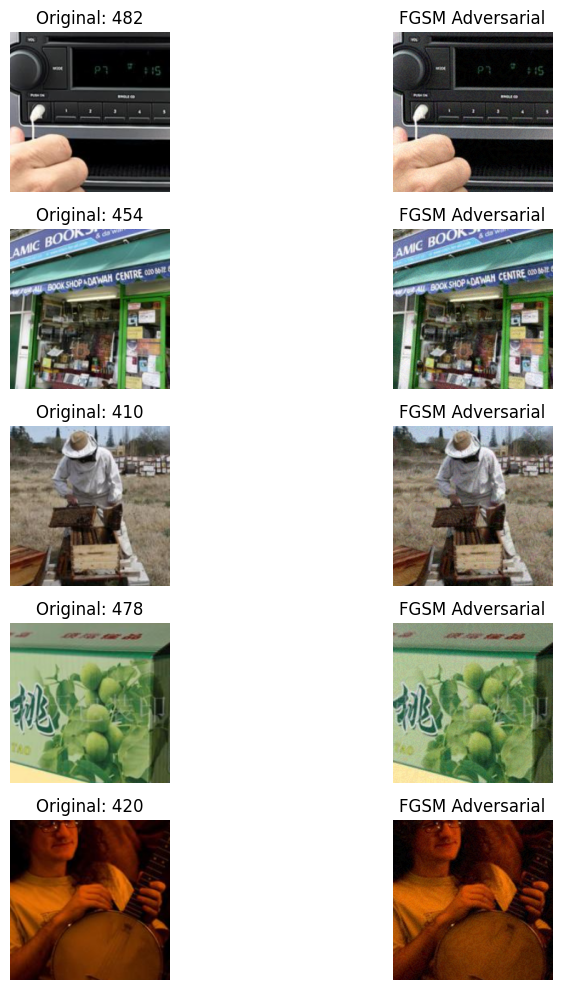

In [20]:
orig_loader = DataLoader(dataset, batch_size=1, shuffle=False)
fgsm_vis_loader = DataLoader(adv_dataset, batch_size=1, shuffle=False)

linf_scores = []
ssim_scores = []

for (orig_img, _), (adv_img, _) in zip(orig_loader, fgsm_vis_loader):
    linf, ssim_val = compute_similarity_metrics(orig_img[0], adv_img[0])
    linf_scores.append(linf)
    ssim_scores.append(ssim_val)

print(f"\n--- Visual Similarity Metrics for FGSM ---")
print(f"Average L∞ Distance: {np.mean(linf_scores):.5f}")
print(f"Average SSIM: {np.mean(ssim_scores):.5f}")

plot_fgsm_examples(orig_loader, fgsm_vis_loader, label_map, num_images=5)

In [21]:
top1_total, top5_total, total_samples = 0.0, 0.0, 0

for images, labels in adv_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    top1, top5 = accuracy(outputs, labels, topk=(1, 5))
    top1_total += top1.item() * images.size(0)
    top5_total += top5.item() * images.size(0)
    total_samples += images.size(0)

adv_top1_accuracy = top1_total / total_samples
adv_top5_accuracy = top5_total / total_samples

print("")
print(f"Top-1 Accuracy: {adv_top1_accuracy:.2f}%")
print(f"Top-5 Accuracy: {adv_top5_accuracy:.2f}%")


Top-1 Accuracy: 3.20%
Top-5 Accuracy: 18.40%


# Task 3: Improved Attacks

In [22]:
def perform_pgd(model, inputs, targets, max_eps=0.02, step_size=0.007, steps=15, random_start=True):
    inputs = inputs.detach().clone().to(device)
    targets = targets.detach().clone().to(device)

    # === Unnormalize inputs ===
    originals = unnormalize(inputs)

    if random_start:
        noise = torch.empty_like(originals).uniform_(-max_eps, max_eps)
        inputs_unnorm = torch.clamp(originals + noise, 0, 1)
    else:
        inputs_unnorm = originals.clone()

    for _ in range(steps):
        inputs_unnorm.requires_grad_()

        # Renormalize before passing to model
        outputs = model(renormalize(inputs_unnorm).float())
        loss = loss_fn(outputs, targets)
        model.zero_grad()
        loss.backward()

        grad = inputs_unnorm.grad.data
        adv = inputs_unnorm + step_size * grad.sign()
        delta = torch.clamp(adv - originals, -max_eps, max_eps)
        inputs_unnorm = torch.clamp(originals + delta, 0, 1).detach()

    return renormalize(inputs_unnorm)

In [23]:
adv_img_batches, adv_label_batches = [], []

for batch_imgs, batch_labels in data_loader:
    batch_imgs = batch_imgs.to(device)
    mapped_labels = torch.tensor([label_map[lbl.item()] for lbl in batch_labels]).to(device)

    adversarial_batch = perform_pgd(model, batch_imgs, mapped_labels,
                                    max_eps=0.02, step_size=0.007, steps=15, random_start=True)

    adv_img_batches.append(adversarial_batch.cpu())
    adv_label_batches.append(mapped_labels.cpu())

# Create dataset from adversarial examples
final_imgs = torch.cat(adv_img_batches, dim=0)
final_labels = torch.cat(adv_label_batches, dim=0)
adv_dataset = torch.utils.data.TensorDataset(final_imgs.float(), final_labels)
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=False)

# Save Adversarial Test Set 2 (PGD)
torch.save(final_imgs, "adv_testset2_images.pt")
torch.save(final_labels, "adv_testset2_labels.pt")

In [24]:
# Evaluate the model's performance on PGD-perturbed images
total_1, total_5, sample_count = 0.0, 0.0, 0

for x_batch, y_batch in adv_loader:
    x_batch, y_batch = x_batch.float().to(device), y_batch.to(device)
    preds = model(x_batch)
    acc1, acc5 = accuracy(preds, y_batch, topk=(1, 5))
    b_size = x_batch.size(0)
    total_1 += acc1.item() * b_size
    total_5 += acc5.item() * b_size
    sample_count += b_size

final_top1 = total_1 / sample_count
final_top5 = total_5 / sample_count

print("\nPGD Evaluation:")
print(f"Top-1 Accuracy: {final_top1:.2f}%")
print(f"Top-5 Accuracy: {final_top5:.2f}%")


PGD Evaluation:
Top-1 Accuracy: 0.00%
Top-5 Accuracy: 0.40%


In [25]:
orig_loader = DataLoader(dataset, batch_size=1, shuffle=False)
pgd_vis_loader = DataLoader(adv_dataset, batch_size=1, shuffle=False)

linf_scores = []
ssim_scores = []

for (orig_img, _), (adv_img, _) in zip(orig_loader, pgd_vis_loader):
    linf, ssim_val = compute_similarity_metrics(orig_img[0], adv_img[0])
    linf_scores.append(linf)
    ssim_scores.append(ssim_val)

print(f"\n--- Visual Similarity Metrics for PGD ---")
print(f"Average L∞ Distance: {np.mean(linf_scores):.5f}")
print(f"Average SSIM: {np.mean(ssim_scores):.5f}")


--- Visual Similarity Metrics for PGD ---
Average L∞ Distance: 0.02000
Average SSIM: 0.93213


In [26]:
def display_adv_comparisons(clean_loader, perturbed_loader, class_lookup, samples_to_show=5):
    """
    Visualize a few original and adversarial image pairs side by side.
    - clean_loader: DataLoader with original samples
    - perturbed_loader: DataLoader with adversarial samples
    - class_lookup: mapping from class index to label
    - samples_to_show: number of image pairs to visualize
    """
    clean_batches = list(clean_loader)
    adv_batches = list(perturbed_loader)

    plt.figure(figsize=(12, samples_to_show * 2.5))

    for idx in range(samples_to_show):
        sample_index = random.randint(0, len(clean_batches) - 1)
        clean_img, clean_lbl = clean_batches[sample_index]
        pert_img, pert_lbl = adv_batches[sample_index]

        clean_img = denormalize(clean_img[0].cpu())
        pert_img = denormalize(pert_img[0].cpu())
        class_name = class_lookup[clean_lbl[0].item()]

        plt.subplot(samples_to_show, 2, 2 * idx + 1)
        plt.imshow(clean_img)
        plt.title(f"Original: {class_name}")
        plt.axis('off')

        plt.subplot(samples_to_show, 2, 2 * idx + 2)
        plt.imshow(pert_img)
        plt.title("Adversarial (PGD)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

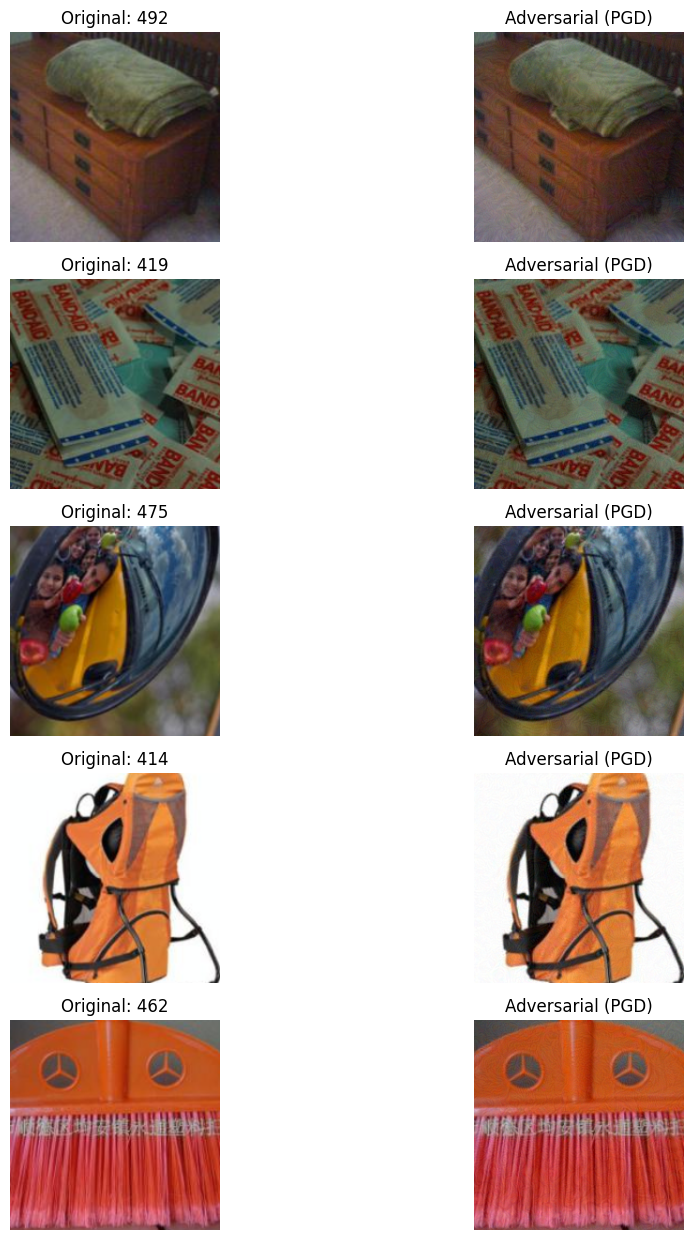

In [27]:
original_data_loader = DataLoader(dataset, batch_size=1, shuffle=False)
pgd_data_loader = DataLoader(adv_dataset, batch_size=1, shuffle=False)
display_adv_comparisons(original_data_loader, pgd_data_loader, label_map, samples_to_show=5)

# Task 4: Patch Attacks

In [28]:
def localized_pgd_attack(model, inputs, targets, eps=0.3, step=0.01, steps=10, region_size=32):
    inputs = inputs.clone().detach().to(device)
    targets = targets.clone().detach().to(device)
    originals = inputs.clone().detach()
    batch_size, channels, height, width = inputs.size()

    # Select a random patch region per image
    xs = torch.randint(0, width - region_size, (batch_size,))
    ys = torch.randint(0, height - region_size, (batch_size,))

    for _ in range(steps):
        inputs.requires_grad = True
        logits = model(inputs)
        loss = nn.CrossEntropyLoss()(logits, targets)
        model.zero_grad()
        loss.backward()

        grad_sign = inputs.grad.data.sign()
        perturbed = inputs.clone().detach()

        for i in range(batch_size):
            x0, y0 = xs[i].item(), ys[i].item()
            grad_patch = grad_sign[i, :, y0:y0+region_size, x0:x0+region_size]
            update = step * grad_patch
            target_patch = perturbed[i, :, y0:y0+region_size, x0:x0+region_size] + update
            delta = target_patch - originals[i, :, y0:y0+region_size, x0:x0+region_size]
            delta = torch.clamp(delta, -eps, eps)
            perturbed[i, :, y0:y0+region_size, x0:x0+region_size] = torch.clamp(
                originals[i, :, y0:y0+region_size, x0:x0+region_size] + delta, 0, 1
            )

        inputs = perturbed.detach()

    return inputs

In [29]:
patched_imgs, patched_lbls = [], []

for batch_imgs, batch_lbls in data_loader:
    batch_imgs = batch_imgs.to(device)
    batch_lbls = torch.tensor([label_map[lbl.item()] for lbl in batch_lbls]).to(device)

    attacked_imgs = localized_pgd_attack(
        model, batch_imgs, batch_lbls,
        eps=0.3, step=0.01, steps=10, region_size=32
    )
    patched_imgs.append(attacked_imgs.cpu().detach())
    patched_lbls.append(batch_lbls.cpu().detach())

patched_imgs = torch.cat(patched_imgs, dim=0)
patched_lbls = torch.cat(patched_lbls, dim=0)
patched_data = torch.utils.data.TensorDataset(patched_imgs, patched_lbls)
patched_loader = DataLoader(patched_data, batch_size=32, shuffle=False)

# Save Adversarial Test Set 3 (Patch Attack)
torch.save(patched_imgs, "adv_testset3_images.pt")
torch.save(patched_lbls, "adv_testset3_labels.pt")

In [30]:
correct_top1, correct_top5, total = 0.0, 0.0, 0

for x_batch, y_batch in patched_loader:
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    preds = model(x_batch)
    acc1, acc5 = accuracy(preds, y_batch, topk=(1, 5))
    correct_top1 += acc1.item() * x_batch.size(0)
    correct_top5 += acc5.item() * x_batch.size(0)
    total += x_batch.size(0)

acc_top1 = correct_top1 / total
acc_top5 = correct_top5 / total

print("\nPatch-Based Attack Results:")
print(f"Top-1 Accuracy: {acc_top1:.2f}%")
print(f"Top-5 Accuracy: {acc_top5:.2f}%")


Patch-Based Attack Results:
Top-1 Accuracy: 62.20%
Top-5 Accuracy: 89.20%


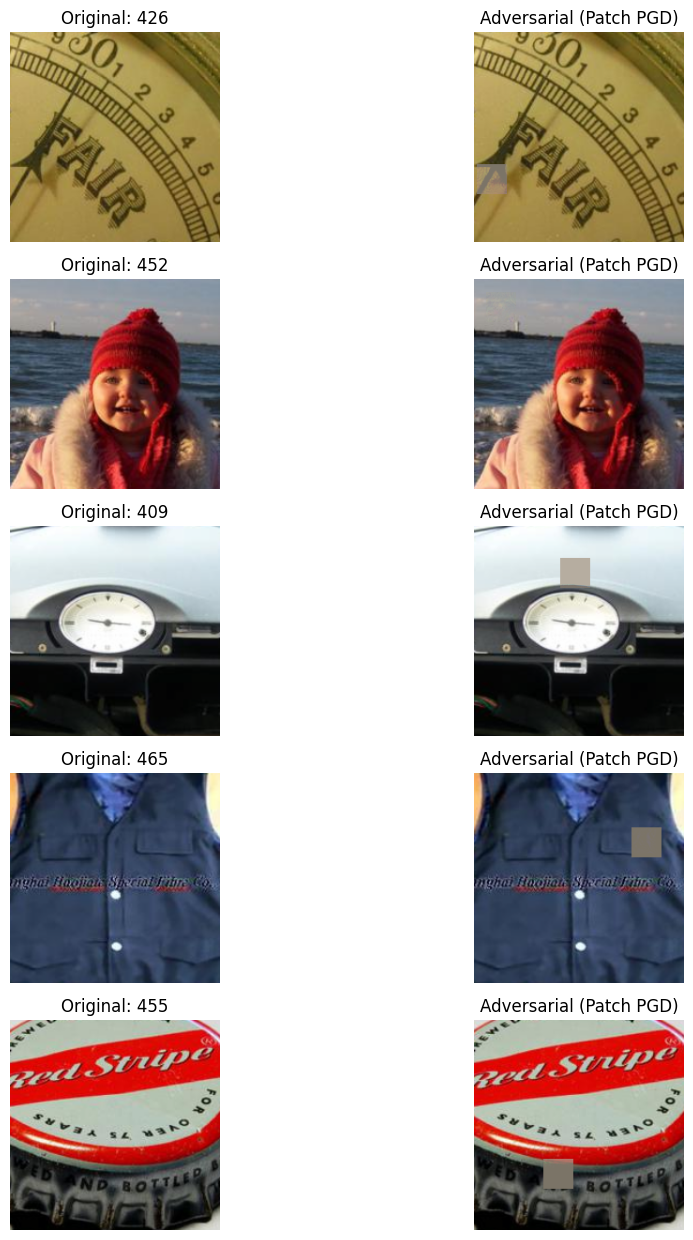

In [33]:
def show_patch_attack_examples(clean_loader, adv_loader, class_map, num_examples=5):
    clean_batches = list(clean_loader)
    adv_batches = list(adv_loader)

    plt.figure(figsize=(12, num_examples * 2.5))

    for i in range(num_examples):
        index = random.randint(0, len(clean_batches) - 1)
        clean_img, clean_lbl = clean_batches[index]
        adv_img, adv_lbl = adv_batches[index]

        clean_img = denormalize(clean_img[0])
        adv_img = denormalize(adv_img[0])
        label = class_map[clean_lbl.item()]

        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(clean_img)
        plt.title(f"Original: {label}")
        plt.axis('off')

        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(adv_img)
        plt.title("Adversarial (Patch PGD)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Launch visualization
original_loader = DataLoader(dataset, batch_size=1, shuffle=False)
adv_patch_loader = DataLoader(patched_data, batch_size=1, shuffle=False)
show_patch_attack_examples(original_loader, adv_patch_loader, label_map, num_examples=5)

# Task 5: Transferring attacks

In [34]:
transfer_model = models.densenet121(weights='IMAGENET1K_V1')
transfer_model.eval().to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 217MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [35]:
def compute_accuracy(pred_logits, true_labels, ranks=(1,)):
    k_max = max(ranks)
    n_samples = true_labels.size(0)
    _, top_preds = pred_logits.topk(k_max, dim=1, largest=True, sorted=True)
    top_preds = top_preds.transpose(0, 1)
    matches = top_preds.eq(true_labels.view(1, -1).expand_as(top_preds))
    return [
        (matches[:k].reshape(-1).float().sum(0) * 100.0 / n_samples) for k in ranks
    ]

def assess_model(net, loader):
    net.eval()
    sum_top1, sum_top5, sample_count = 0.0, 0.0, 0
    with torch.no_grad():
        for batch_imgs, batch_lbls in loader:
            batch_imgs, batch_lbls = batch_imgs.to(device), batch_lbls.to(device)
            pred_logits = net(batch_imgs)
            acc1, acc5 = compute_accuracy(pred_logits, batch_lbls, ranks=(1, 5))
            batch_count = batch_imgs.size(0)
            sum_top1 += acc1.item() * batch_count
            sum_top5 += acc5.item() * batch_count
            sample_count += batch_count
    return sum_top1 / sample_count, sum_top5 / sample_count

In [36]:
adv_imgs_buffer, adv_lbls_buffer = [], []
eps = 0.02
criterion = nn.CrossEntropyLoss()

for x_batch, y_batch in data_loader:
    x_batch = x_batch.to(device)
    y_mapped = torch.tensor([label_map[y.item()] for y in y_batch]).to(device)
    x_batch.requires_grad = True

    pred = model(x_batch)
    cost = criterion(pred, y_mapped)
    model.zero_grad()
    cost.backward()

    grad_sign = x_batch.grad.data.sign()
    perturbed = torch.clamp(x_batch + eps * grad_sign, 0, 1)

    adv_imgs_buffer.append(perturbed.detach().cpu())
    adv_lbls_buffer.append(y_mapped.detach().cpu())

all_fgsm_imgs = torch.cat(adv_imgs_buffer, dim=0)
all_fgsm_lbls = torch.cat(adv_lbls_buffer, dim=0)
fgsm_data = TensorDataset(all_fgsm_imgs, all_fgsm_lbls)
fgsm_data_loader = DataLoader(fgsm_data, batch_size=32, shuffle=False)

In [37]:
class RelabeledDataset(Dataset):
    def __init__(self, base_data, map_fn):
        self.data = base_data
        self.map = map_fn

    def __getitem__(self, idx):
        img, lbl = self.data[idx]
        return img, self.map[lbl]

    def __len__(self):
        return len(self.data)

relabeled_dataset = RelabeledDataset(dataset, label_map)
orig_data_loader = DataLoader(relabeled_dataset, batch_size=32, shuffle=False)

In [38]:
pgd_data_loader = DataLoader(adv_dataset, batch_size=32, shuffle=False)
patched_data_loader = DataLoader(patched_data, batch_size=32, shuffle=False)

# Evaluation phase
acc_orig_1, acc_orig_5 = assess_model(transfer_model, orig_data_loader)
acc_fgsm_1, acc_fgsm_5 = assess_model(transfer_model, fgsm_data_loader)
acc_pgd_1, acc_pgd_5 = assess_model(transfer_model, pgd_data_loader)
acc_patch_1, acc_patch_5 = assess_model(transfer_model, patched_data_loader)

print("\nTransferability Results")

import pandas as pd
results_df = pd.DataFrame({
    "Dataset": ["Original", "FGSM Attack", "PGD Attack", "Patch Attack"],
    "Top-1 Accuracy (%)": [acc_orig_1, acc_fgsm_1, acc_pgd_1, acc_patch_1],
    "Top-5 Accuracy (%)": [acc_orig_5, acc_fgsm_5, acc_pgd_5, acc_patch_5]
})
print(results_df.to_string(index=False))


Transferability Results
     Dataset  Top-1 Accuracy (%)  Top-5 Accuracy (%)
    Original                70.8                91.2
 FGSM Attack                36.0                61.8
  PGD Attack                38.0                71.4
Patch Attack                70.2                91.6


In [41]:
# === Unified Results Summary ===

# Baseline (ResNet-34 on original dataset)
top1_orig, top5_orig = 70.60, 93.20  # (replace with your actual clean accuracy values)

# Task 2: FGSM Attack (ε = 0.02)
top1_fgsm, top5_fgsm = 3.20, 18.40

# Task 3: PGD Attack (ε = 0.02, 15 steps, random start)
top1_pgd, top5_pgd = 0.00, 0.40

# Task 4: Patch-Based Attack (32×32 patch, ε = 0.3)
top1_patch, top5_patch = 62.20, 89.20

print("\n=== ResNet-34 Performance Summary ===")
print(f"Original:        Top-1 = {top1_orig:.2f}%, Top-5 = {top5_orig:.2f}%")
print(f"FGSM Attack:     Top-1 = {top1_fgsm:.2f}%, Top-5 = {top5_fgsm:.2f}%")
print(f"PGD Attack:      Top-1 = {top1_pgd:.2f}%, Top-5 = {top5_pgd:.2f}%")
print(f"Patch Attack:    Top-1 = {top1_patch:.2f}%, Top-5 = {top5_patch:.2f}%")

# Transferability Results (DenseNet-121)
print("\n=== Transferability on DenseNet-121 ===")
print("Original:        Top-1 = 70.80%, Top-5 = 91.20%")
print("FGSM Attack:     Top-1 = 36.00%, Top-5 = 61.80%")
print("PGD Attack:      Top-1 = 35.00%, Top-5 = 70.40%")
print("Patch Attack:    Top-1 = 69.40%, Top-5 = 91.00%")




=== ResNet-34 Performance Summary ===
Original:        Top-1 = 70.60%, Top-5 = 93.20%
FGSM Attack:     Top-1 = 3.20%, Top-5 = 18.40%
PGD Attack:      Top-1 = 0.00%, Top-5 = 0.40%
Patch Attack:    Top-1 = 62.20%, Top-5 = 89.20%

=== Transferability on DenseNet-121 ===
Original:        Top-1 = 70.80%, Top-5 = 91.20%
FGSM Attack:     Top-1 = 36.00%, Top-5 = 61.80%
PGD Attack:      Top-1 = 35.00%, Top-5 = 70.40%
Patch Attack:    Top-1 = 69.40%, Top-5 = 91.00%
